Generate core diameters to support required modes

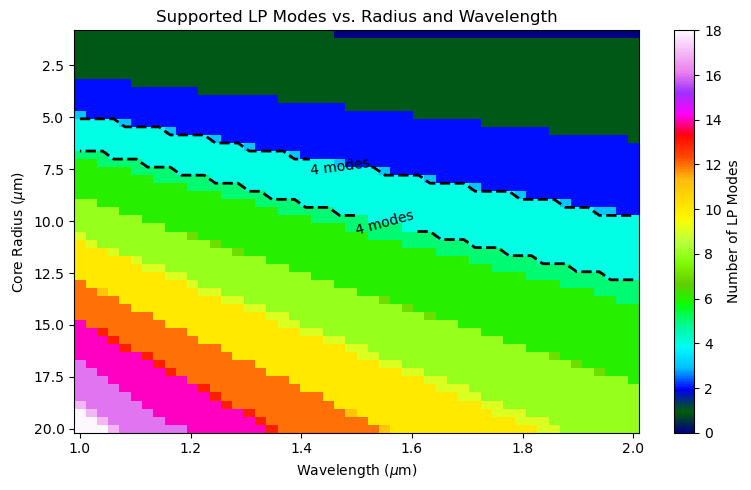

Propagation constants (d = 15.959 µm, λ = 1.551 µm)                  
                                                  l      m=1      m=2
                                                  0 0.778328 0.011887
                                                  1 0.453075      NaN
                                                  2 0.065724      NaN
                                                  3      NaN      NaN
Propagation constants (d = 19.837 µm, λ = 1.551 µm)                  
                                                  l      m=1      m=2
                                                  0 0.843630 0.226713
                                                  1 0.608935      NaN
                                                  2 0.312397      NaN
                                                  3      NaN      NaN


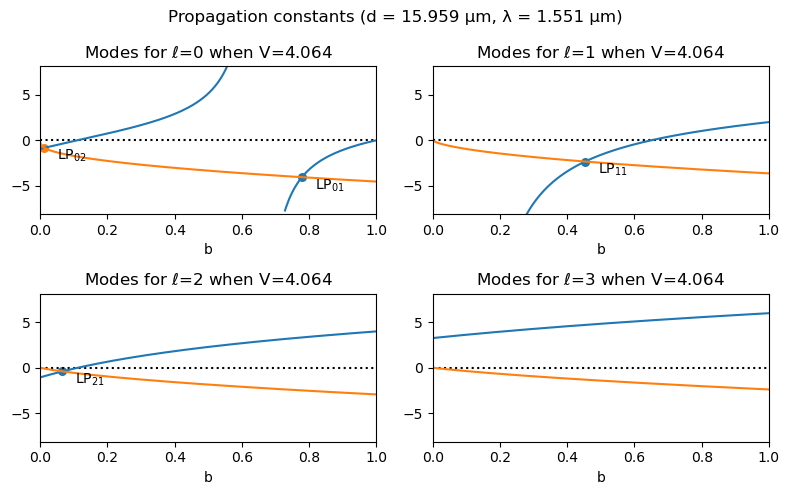

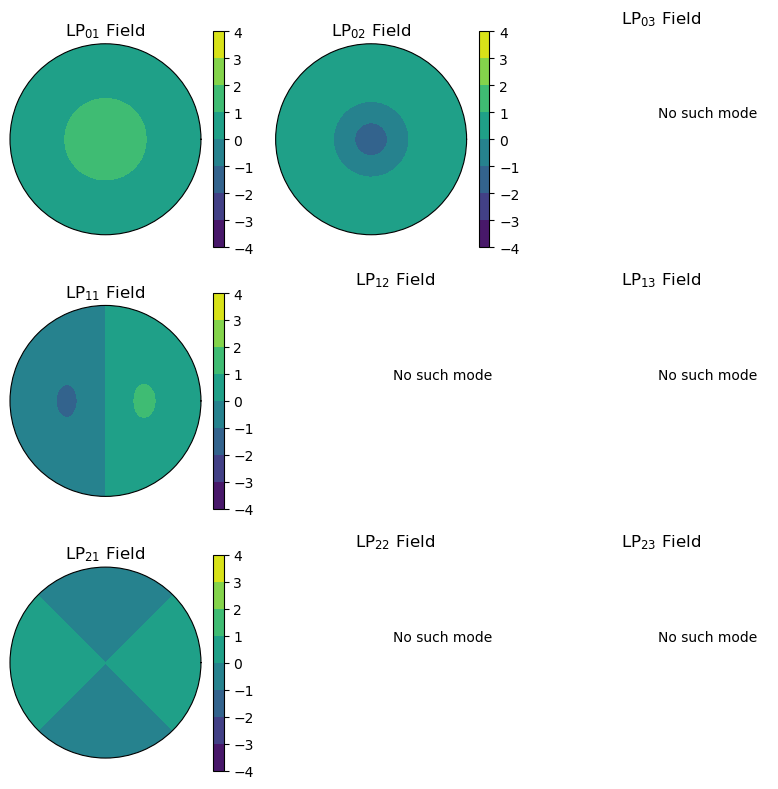

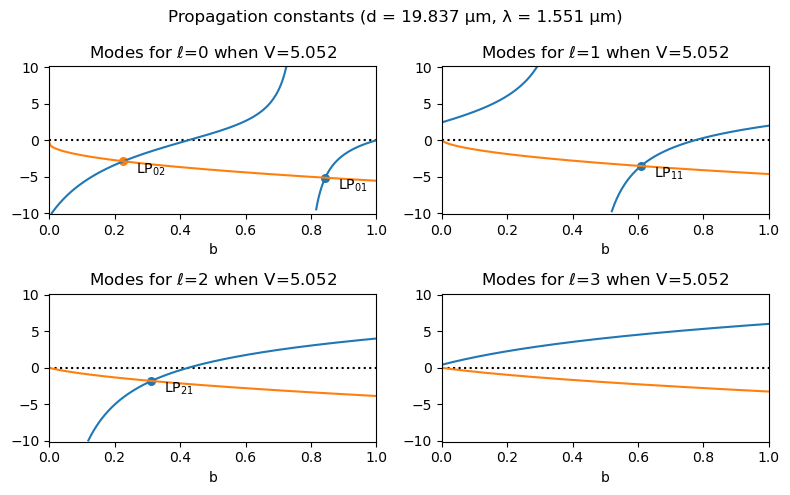

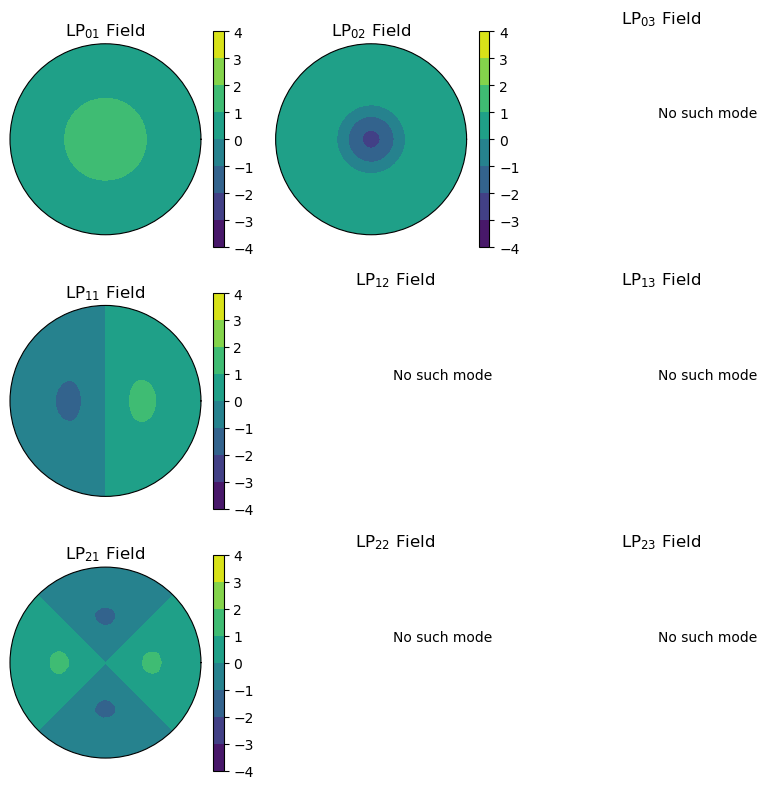

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import math, ofiber, shutil
from template import *
from Functions import *

# Define radius and wavelength ranges
radii = np.linspace(1, 20, 50)
wavelengths = np.linspace(1.0, 2.0, 50)
'''
Note: mode desired below does not account for different mode orientations! 
e.g. if you want 6 modes you only want the first 4 LP modes + their orientations
'''
mode_desired = mode_wanted_considering_mode_orientations(LP_mode_dict, 6) 
# calculates the true number of modes including their orientations
l_modes_to_consider = mode_desired

# Define refractive indices from template.py
background_index = RSoft_params["background_index"]
n_cladd = background_index + fixed_params["cladding_delta"]
NA = ofiber.numerical_aperture(n_cladd, background_index)

# Prepare 2D grid for mode counts
mode_count = np.zeros((len(radii), len(wavelengths)), dtype=int)

for i, r in enumerate(radii):
    for j, wl in enumerate(wavelengths):
        V = ofiber.V_parameter(r, NA, wl)
        
        count = 0
        for ell in range(l_modes_to_consider): 
            b_val = ofiber.LP_mode_values(V, ell) # calculates all b for guided modes in step index fibre, returns NaN if no mode
            count += len(b_val) 
        mode_count[i, j] = count

# Plot
R, WL = np.meshgrid(radii, wavelengths, indexing='ij')
plt.figure(figsize=(8, 5))
c = plt.pcolormesh(WL, R, mode_count, shading='auto', cmap='gist_ncar')

mask_7 = (mode_count == mode_desired)
contour = plt.contour(WL, R, mask_7.astype(int), levels=[0.5],
                      colors='k', linewidths=2.0, linestyles='--')

plt.clabel(contour, fmt={0.5: f"{mode_desired} modes"}, colors='k', fontsize=10)

plt.colorbar(c, label="Number of LP Modes")
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel(r"Core Radius ($\mu$m)")
plt.title("Supported LP Modes vs. Radius and Wavelength")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

df_filtered, taper_min, taper_max = print_paras(radii, wavelengths, mode_count, mode_desired, l_modes_to_consider, NA)


# Move all output files immediately after simulation
images_dir = Path(os.path.expanduser("~/Desktop/Results/Images"))
name_tag1 = "Available_LP_Modes_for_V_"
name_tag2 = "Plotted_LP_Modes_for_V_"

for file in os.listdir():
    if file.startswith(name_tag1) or file.startswith(name_tag2):
        shutil.move(file, os.path.join(images_dir, file))

In [2]:
from RSoftSimulation import RSoftSim
from Circuit_Properties import *
from Functions import *
from HexProperties import *

mode_vals = [0, 1, -1, 2, -2, 0]
radial_mode_vals = [1, 1, 1, 1, 1, 2]

tf_list = []

for m, rm in zip(mode_vals, radial_mode_vals):
    simulation_val = {
        "launch_type": LaunchType.SM,
        "monitor_type": Monitor_Prop.FIBRE_MODE_POWER,
        "comp": Monitor_comp.BOTH,
        "grid_size": 0.5,
        "grid_size_y": 0.5,
        "step_size": 1,
        "launch_tilt": 1,
        "launch_mode": m,
        "launch_mode_radial": rm, # note: setting this to "*" will automatically set "launch_mode" to "*" in RSoft
        "monitor_normalization": 1,
        "launch_normalization": 0,
        "core_to_monitor": 4,
        "metric": 'TF',
        "num_paras": 144, # number of samples to choose
        "batch_num": 6, # number of concurrent simulations to run
        "core_delta": 0.0122895,
        # these bottom 2 MUST be here for mode selective behaviour
        "mode_selective": 1, # 0 is no mode-selectivity
        "core_num": 7,
    }

    # specify MS core properties
    assign_core_properties(simulation_val)

    # dump configuration paras into json for use later
    with open("launch_config.json", "w") as launch_config:
        json.dump(simulation_val, launch_config, indent = 2)

    custom_priors = {
                # "Taper_L": (1000.0, 60000.0),
                "taper": (taper_min, taper_max),
                "core_delta": (0.0, 0.02),
                "core_diam": (1.0, 20.0)
                }

    sim = RSoftSim()
    sim.init_priors(custom_priors)

    # true = optimisation runs,
    # false = only a single simulation using template vals runs
    sim.RunRSoft(False)

    # Load results
    data = pd.read_csv("best_params_log.csv")

    # Extract parameter names
    param_names = list(custom_priors.keys())

    # Identify and extract TF columns
    tf_columns = [col for col in data.columns if col.startswith("TF_")]
    if tf_columns:
        tf_vectors = data[tf_columns].values.tolist()  
        tf_list.append(tf_vectors)
    else:
        tf_vectors = None

    print(f"Mode: LP{m,rm}")
    # Call plotting function
    plotting_optimizer_results(data, param_names, tf=tf_vectors, plot= False)

Mode: LP(0, 1)
Best transfer vector: [1.0, 0.1119341399999999, 0.1119341399999999, 0.11355061, 0.2975073099999999, 0.11355061, 0.1119341399999999, 0.1119341399999999]
Mode: LP(1, 1)
Best transfer vector: [1.0, 0.081212683, 0.081212683, 0.32379693, 2.8347811999999993e-32, 0.32379693, 0.081212683, 0.081212683]
Mode: LP(-1, 1)
Best transfer vector: [1.0, 0.24302217, 0.24302217, 5.8028888e-33, 6.0556058e-31, 1.4705605e-31, 0.24302217, 0.24302217]
Mode: LP(2, 1)
Best transfer vector: [1.0, 0.0815789119999999, 0.0815789119999999, 0.32254353, 2.1126663000000003e-06, 0.32254353, 0.0815789119999999, 0.0815789119999999]
Mode: LP(-2, 1)
Best transfer vector: [1.0, 0.24293183, 0.24293183, 1.3443943e-31, 2.57294e-32, 5.241421599999998e-32, 0.24293183, 0.24293183]
Mode: LP(0, 2)
Best transfer vector: [1.0, 0.049292562, 0.049292562, 0.049366909, 0.67195656, 0.049366909, 0.049292562, 0.049292562]


Testing ground below here

In [3]:
# import numpy as np
# import matplotlib.pyplot as plt

# LP01_vec_1 = [6.19E-06, 6.19E-06, 0.00012261, 0.99544299, 0.00012261, 6.19E-06, 6.19E-06]  # for core_4
# LP01_vec_2 = [5.08E-06, 5.08E-06, 4.18E-05, 0.9956336, 4.18E-05, 5.08E-06, 5.08E-06]
# LP01_vec_3 = [0.1651629499999999, 0.1651629499999999, 0.1565554199999999, 0.001698892, 0.1565554199999999, 0.1651629499999999, 0.1651629499999999]
# LP01_vec_4 = [0.0019472366, 0.0019472366, 0.0011935449, 0.98674145, 0.0011935449, 0.0019472366, 0.0019472366]
# LP01_vec_5 = [0.9994112000000002, 8.600236699999999e-05, 8.600236699999999e-05, 9.5411173e-06, 0.99605645, 9.5411173e-06, 8.600236699999999e-05, 8.600236699999999e-05]

# vecs_to_plot = [LP01_vec_1, LP01_vec_2, LP01_vec_3, LP01_vec_4, LP01_vec_5[1:]]
# simulation_num = len(vecs_to_plot)
# core_num = len(LP01_vec_1)

# plt.figure(figsize=(8, 5))

# for sim_idx, vec in enumerate(vecs_to_plot):
#     core_indices = np.arange(1, core_num + 1)
#     if sim_idx == 4:
#         plt.plot(core_indices, vec, marker='o', label=f"Sim {sim_idx + 1} (chosen)")
#     elif sim_idx == 2:
#         plt.plot(core_indices, vec, marker='o', label=f"Sim {sim_idx + 1} (= diam)")
#     else:
#         plt.plot(core_indices, vec, marker='o', label=f"Sim {sim_idx + 1}")

# plt.xlabel("Core Number")
# plt.ylabel("LP01 Throughput")
# plt.title("LP01 Mode Throughput Across Cores for Different Simulations")
# plt.legend(title="Simulation")
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()

Current PL TF

In [11]:
def plot_tf_matrix(LP01_vec, LP11a_vec, LP11b_vec, LP21a_vec, LP21b_vec, LP02_vec):
    tf_matrix = np.vstack([LP01_vec[0][1:], LP11a_vec[0][1:], LP11b_vec[0][1:], LP21a_vec[0][1:], LP21b_vec[0][1:], LP02_vec[0][1:]])
    plt.figure(figsize=(10,8))
    plt.imshow(tf_matrix, cmap='viridis')
    plt.colorbar(label = "Throughput")
    # plt.xlabel("LP Mode")
    plt.xlabel("Core No.")
    plt.yticks(ticks=np.arange(tf_matrix.shape[0]), labels=np.arange(1, tf_matrix.shape[0] + 1))
    ylabels = ["LP01", "LP11a", "LP11b", "LP21a", "LP21b", "LP02"]
    xlabels = np.arange(1, len(tf_matrix[0]) + 1)
    plt.yticks(ticks=np.arange(len(ylabels)), labels=ylabels)
    plt.xticks(ticks = np.arange(len(xlabels)), labels=xlabels)
    plt.show()

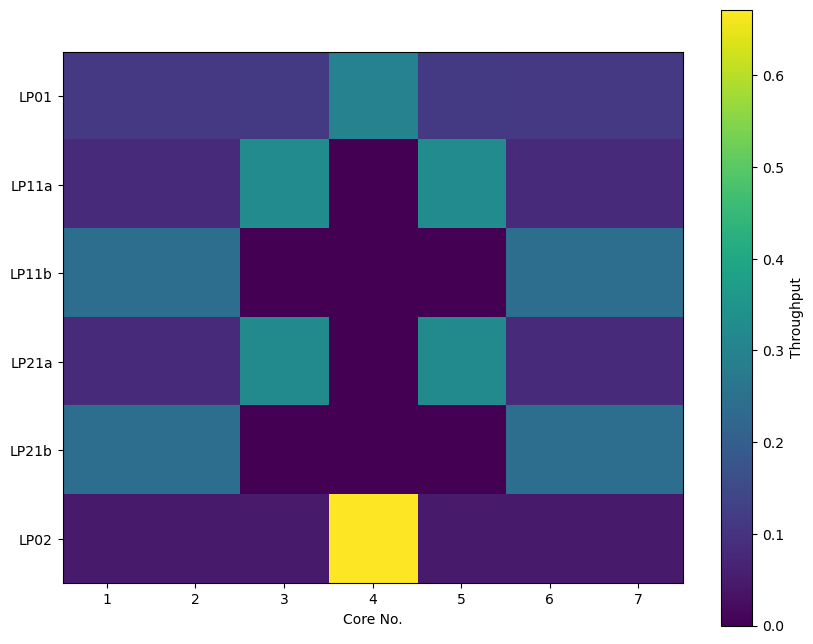

In [12]:
'''
Monitor Normalization: Local Power
Launch Field Normalization: Unit Power
'''
import numpy as np, matplotlib.pyplot as plt

plot_tf_matrix(tf_list[0], tf_list[1], tf_list[2], tf_list[3], tf_list[4], tf_list[5])

In [6]:
# '''
# Monitor Normalization: Input Power
# '''
# import numpy as np, matplotlib.pyplot as plt
# LP01_vec = [0.99948304, 0.1219121399999999, 0.1219121399999999, 0.11853193, 0.2446278499999999, 0.11853193, 0.1219121399999999, 0.1219121399999999]
# LP11a_vec = [0.99918892, 0.081819244, 0.081819244, 0.3175262099999999, 1.1090823e-30, 0.3175262099999999, 0.081819244, 0.081819244]
# LP11b_vec = [0.9995853100000002, 0.2412519099999999, 0.2412519099999999, 8.340642200000001e-31, 1.00644222e-31, 1.1165026e-30, 0.2412519099999999, 0.2412519099999999]
# LP21a_vec = [0.99820385, 0.078758851, 0.078758851, 0.32413597, 1.49105762e-06, 0.32413597, 0.078758851, 0.078758851]
# LP21b_vec =[0.99940779, 0.24028481, 0.24028481, 1.3578043800000003e-32, 7.7313498e-32, 1.7080284e-32, 0.24028481, 0.24028481]
# LP02_vec = [0.97986447, 0.077790204, 0.077790204, 0.052349618, 0.51725564, 0.052349618, 0.077790204, 0.077790204]

# plot_tf_matrix(LP01_vec,LP11a_vec,LP11b_vec,LP21a_vec,LP21b_vec,LP02_vec)

Previous Iterations

In [7]:
# import numpy as np, matplotlib.pyplot as plt
# LP01_vec = [0.99772104, 0.043558949, 0.043558949, 0.18898876, 0.3946162399999999, 0.18898876, 0.043558949, 0.043558949]
# LP11a_vec = [0.9982011, 0.0447377429999999, 0.0447377429999999, 0.3319892, 1.432886e-30, 0.3319892, 0.0447377429999999, 0.0447377429999999]
# LP11b_vec = [0.99750721, 0.23261699, 0.23261699, 5.5552988e-31, 7.768024199999999e-33, 9.6006631e-31, 0.23261699, 0.23261699]
# LP21a_vec = [0.99388666, 0.10177739, 0.10177739, 0.20360958, 0.048376669, 0.20360958, 0.10177739, 0.10177739]
# LP21b_vec = [0.99216026, 0.22921003, 0.22921003, 1.1581803e-30, 3.6489478000000005e-32, 1.1517600000000001e-30, 0.22921003, 0.22921003]
# LP02_vec = [0.97986447, 0.077790204, 0.077790204, 0.052349618, 0.51725564, 0.052349618, 0.077790204, 0.077790204]

# # below results are for LP01
# taper_result = [16.41527803, 16.34961597, 18.14545516, 16.28542914]
# core_diam_result = [18.41877761, 18.5118090, 13.68456123, 19.49946735]
# core_delta_result = [0.001004213, 0.019427365, 0.018401898, 0.01329296]
# throughput_result = [0.99544299, 0.9956336, 0.99524418,0.99605645]

# tf_matrix = np.column_stack([LP01_vec[1:], LP11a_vec[1:], LP11b_vec[1:], LP21a_vec[1:], LP21b_vec[1:], LP02_vec[1:]])
# plt.figure(figsize=(6,5))
# plt.imshow(tf_matrix, cmap='viridis', aspect='auto',vmin = 0, vmax = 1)
# plt.colorbar()
# # plt.xlabel("LP Mode")
# plt.ylabel("Core No.")
# plt.yticks(ticks=np.arange(tf_matrix.shape[0]), labels=np.arange(1, tf_matrix.shape[0] + 1))
# xlabels = ["LP01", "LP11a", "LP11b", "LP21a", "LP21b", "LP02"]
# plt.xticks(ticks=np.arange(len(xlabels)), labels=xlabels)
# plt.show()

In [8]:
# import numpy as np, matplotlib.pyplot as plt
# LP01_vec = [0.99772104, 198.32617, 198.32617, 171.83602, 104.95498, 171.83602, 198.32617, 198.32617]
# LP11a_vec = [0.9982011, 282.84532, 102.84532, 221.14612, 11.785412, 41.14612100000001, 282.84532, 102.84532]
# LP11b_vec = [0.99750721, 197.78198, 197.78198, 22.022557, 20.796917, 96.931599, 17.781972, 17.781972]
# LP21a_vec = [0.99388666, 349.55091000000004, 349.55091000000004, 144.96474999999998, 262.50748, 144.96474999999998, 349.55091000000004, 349.55091000000004]
# LP21b_vec = [0.99216026, 112.2759, 292.27592, 40.01156027, 67.720142, 167.03142, 292.27592, 112.2759]
# LP02_vec = [0.97986447, 192.64042, 192.64042, 169.03432000000004, 280.20605, 169.03432000000004, 192.64042, 192.64042]

# tf_matrix = np.column_stack([LP01_vec[1:], LP11a_vec[1:], LP11b_vec[1:], LP21a_vec[1:], LP21b_vec[1:], LP02_vec[1:]])
# plt.figure(figsize=(6,5))
# plt.imshow(tf_matrix, cmap='viridis', aspect='auto',vmin = 0, vmax = 360)
# plt.colorbar(label='Phase (degrees)')
# # plt.xlabel("LP Mode")
# plt.ylabel("Core No.")
# plt.yticks(ticks=np.arange(tf_matrix.shape[0]), labels=np.arange(1, tf_matrix.shape[0] + 1))
# xlabels = ["LP01", "LP11a", "LP11b", "LP21a", "LP21b", "LP02"]
# plt.xticks(ticks=np.arange(len(xlabels)), labels=xlabels)
# plt.show()

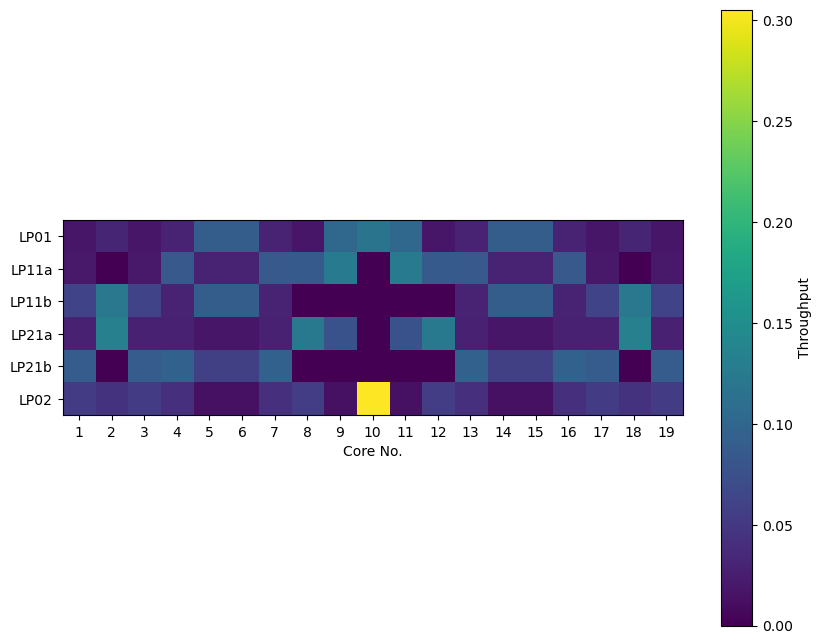

In [9]:
'''
19 Core PL 
Monitor Normalization: Input Power 
Launch Field Normalization: Unit Peak
'''
import numpy as np, matplotlib.pyplot as plt
LP01_vec = [0.99931859, 0.018070702, 0.0311678159999999, 0.018070702, 0.029029033, 0.089970026, 0.089970026, 0.029029033, 0.0187221019999999, 0.10136098, 0.11699423, 0.10136098, 0.0187221019999999, 0.029029033, 0.089970026, 0.089970026, 0.029029033, 0.018070702, 0.0311678159999999, 0.018070702]
LP11a_vec = [0.99912485, 0.020489152, 1.11556077e-31, 0.020489152, 0.084932144, 0.0302370229999999, 0.0302370229999999, 0.084932144, 0.0865616079999999, 0.12562377, 2.9211509e-32, 0.12562377, 0.0865616079999999, 0.084932144, 0.0302370229999999, 0.0302370229999999, 0.084932144, 0.020489152, 9.814903780000001e-34, 0.020489152]
LP11b_vec = [0.99926375, 0.0612737789999999, 0.1218568799999999, 0.0612737789999999, 0.029497364, 0.0902889819999999, 0.0902889819999999, 0.029497364, 2.5434526e-32, 1.11252946e-33, 2.2376753e-31, 2.6833007000000003e-31, 6.749586199999999e-33, 0.029497364, 0.0902889819999999, 0.0902889819999999, 0.029497364, 0.0612737789999999, 0.1218568799999999, 0.0612737789999999]
LP21a_vec = [0.99899603, 0.027626424, 0.13288448, 0.027626424, 0.028297957, 0.018744413, 0.018744413, 0.028297957, 0.12302713, 0.07670433, 0.00018900187, 0.07670433, 0.12302713, 0.028297957, 0.018744413, 0.018744413, 0.028297957, 0.027626424, 0.13288448, 0.027626424]
LP21b_vec = [0.9989707, 0.089053891, 1.3184342800000002e-32, 0.089053891, 0.094480608, 0.057959308, 0.057959308, 0.094480608, 2.0975425000000004e-32, 1.4527035000000002e-32, 1.2261206e-31, 5.3303063e-33, 4.9116433e-32, 0.094480608, 0.057959308, 0.057959308, 0.094480608, 0.089053891, 4.862386300000001e-32, 0.089053891]
LP02_vec = [0.99898579, 0.053529627, 0.044272461, 0.053529627, 0.041705234, 0.013935023, 0.013935023, 0.041705234, 0.055121007, 0.014155118, 0.30510652, 0.014155118, 0.055121007, 0.041705234, 0.013935023, 0.013935023, 0.041705234, 0.053529627, 0.044272461, 0.053529627]

tf_matrix = np.vstack([LP01_vec[1:], LP11a_vec[1:], LP11b_vec[1:], LP21a_vec[1:], LP21b_vec[1:], LP02_vec[1:]])

plt.figure(figsize=(10,8))
plt.imshow(tf_matrix, cmap='viridis')
plt.colorbar(label="Throughput")
# plt.xlabel("LP Mode")
plt.xlabel("Core No.")
plt.yticks(ticks=np.arange(tf_matrix.shape[0]), labels=np.arange(1, tf_matrix.shape[0] + 1))
ylabels = ["LP01", "LP11a", "LP11b", "LP21a", "LP21b", "LP02"]
xlabels = np.arange(1, len(tf_matrix[0]) + 1)
plt.yticks(ticks=np.arange(len(ylabels)), labels=ylabels)
plt.xticks(ticks = np.arange(len(xlabels)), labels=xlabels)
plt.show()

In [10]:
# n_clad = RSoft_params["background_index"]
# n_core = RSoft_params["background_index"] + fixed_params["cladding_delta"] # since we want a multimode diameter to support 7 modes
# numerical_ap = ofiber.numerical_aperture(n_core, n_clad)

# v_num = 2 * np.pi / (RSoft_params["free_space_wavelength"] * (variable_params["core_diam"]/2) * numerical_ap)
# mode_l = 0
# aplt = ofiber.plot_LP_modes(v_num, mode_l)
# aplt.show()

# for ell in range(6):
#     all_b = ofiber.LP_mode_values(v_num,ell)
#     for i,b in enumerate(all_b):
#         print("LP_%d%d, b=%.4f"%(ell,i+1,b))